In [2]:
import numpy as np
from numpy import linalg as LA
import optim_tools as optim_tools#own file with helper

A0 = np.matrix([[0,   1,       0],
                [-10, -1.167, 25],
                [0,   0,    -0.8]])
b0 = np.matrix([[0],[0],[2.4]])
c0 = np.matrix([1, 0, 0])
d0 = np.matrix([0])
T = np.arange(0, 5, 1e-2) 
s = np.zeros(len(T))
u_max = 10.5
pmin = 0.1
X00 = [np.matrix([-20.0, -10.0, -10.0]).T,
       np.matrix([-20.0, -10.0, 10.0]).T,
       np.matrix([-20.0,  10.0, -10.0]).T,
       np.matrix([20.0,  -10.0, 10.0]).T,
       np.matrix([20.0,  -10.0, -10.0]).T,
       np.matrix([20.0,   10.0, 10.0]).T]

A = np.matrix([[0.00000,    1.00000,    0.00000],
               [-0.00000,    0.00000,    1.00000],
               [-8.00000,  -10.93360,   -1.96700]])

a = np.matrix([8.0000,   10.9336,    1.9670]).T

a_hat = np.matrix([7.9991,   10.9325,    1.9676]).T

R1 = np.matrix([[4.04336,   5.48881,   0.66271],
               [5.48881,   7.91988,   1.30004],
               [0.66271,   1.30004,   0.97792]])

T1 = np.matrix([[0.01667,   0.00000,   0.00000],
               [0.00000,   0.01667,   0.00000],
                [-0.16667,  -0.01945,   0.41667]])

X0 = [T1.dot(x0) for x0 in X00]

In [3]:
from scipy.optimize import minimize
p_init = 0.1
last_p = p_init

def contr_func(y, s, x, u_max, a, a_hat, R1, T1=None):
    global last_p, pmin
    
    # Transformation in Regelungsnormalform
    if T1 is None:
        T1 = np.eye(len(x))

    x_R = T1*x
    
    func_g = lambda p: np.absolute(get_g(p, x_R, R1, u_max, a, a_hat))
    res = minimize(func_g, last_p, method='Nelder-Mead') # find 0 -fzero
    
    # Saturate if too small
    if res.x < pmin:
        p = pmin
    elif res.x > 1.0:
        p = 1.0
        print "WARNING: p=({})>1! -> p is saturated to 1.0".format(res.x)
    else:
        p = res.x

    p_t.append(p)
    p2_t.append(res.x)

    last_p = p
    
    ## Calc K according to p
    K = get_k(p, a, a_hat)

    # Calc u
    u = s-K.T.dot(x_R)
    
    # Saturate u
    u = optim_tools.sat(u, u_max)
    #print "u", u
    
    return u

In [4]:
def get_g(v, x, R1, u_max, a, a_hat):
    try:
        v = v.squeeze() # This is weird, needed for minimize for some reason
    except:
        pass
    D_inv = optim_tools._D_inv(v, len(x))
    R = D_inv.dot(R1).dot(D_inv) # R(v) = D^⁻1 * R1 * D^-1
    
    k = get_k(v, a, a_hat) # k(v)
    e = (u_max**(-2)) * (k.T.dot(LA.inv(R)).dot(k))
    #assert e < 1.0
    g = e*(x.T.dot(R).dot(x)) - 1.0
    #assert g <= 0, "g = {} > 0".format(g)
    # Update 2016: As of python 3.5, there is a new matrix_multiply symbol, @:
    # g = x' @ D^-1 @ R1 @ D^-1 @ x - 1.0
    return g

In [5]:
# k(v) (4.5)
def get_k(v, a, a_hat):
    try:
        v = v.squeeze() # This is weird, needed for minimize for some reason
    except:
        pass
    D_inv = optim_tools._D_inv(v, len(a))
    #print D_inv
    k = D_inv.dot(a_hat) - a
    return k

In [6]:
p_t = []
p2_t = []

y, u, u_sat = optim_tools.simulate(A0, b0, c0, d0, lambda y, s, x: contr_func(y, s, x, u_max, a, a_hat, R1, T1), s, T, umax=u_max, x0=x0)

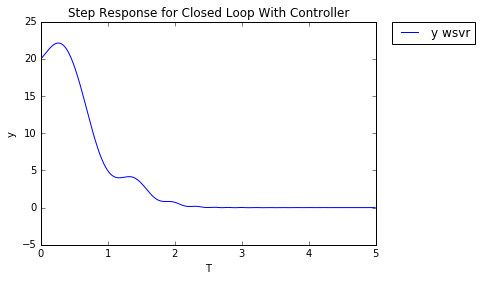

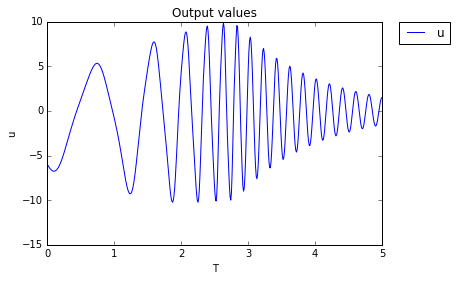

In [7]:
import matplotlib.pyplot as plt

#plt.figure()
line0, = plt.plot(T[:], np.array(y[0,:].T), 'b', label='y wsvr')



#first_legend = plt.legend(handles=[line1], loc=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('T')
plt.ylabel('y')
plt.title('Step Response for Closed Loop With Controller')
plt.show()

#plt.figure()
line0, = plt.plot(T, u_sat, 'b', label='u')


#>first_legend = plt.legend(handles=[line1, line2, line1b, line2b], loc=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel('T')
plt.ylabel('u')
plt.title('Output values')
plt.show()